In [8]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import scipy.stats as stats

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

import shapely.geometry as sg
from shapely.geometry import Point

import sys
sys.path.append(os.path.abspath(".."))
from function import DOWN_raw
from function import ART_preprocessing as ART_pre

from playsound import playsound

import warnings
warnings.filterwarnings('ignore')

In [9]:
correction, nameout, label = 'quantile-quantile', 'QQc', 'ISIMIP_QM'
# correction, nameout, label = 'linear-regression', 'LRc', 'Linear Regression'

print(f'Correction method: {correction}')

Correction method: quantile-quantile


In [10]:
ENSEMBLE_SAT = 'ALL'
# product, time_reso = 'ENSEMBLE_mean', '1dy'
product, time_reso = 'ENSEMBLE_median', '1dy'

# product, time_reso = 'IMERG', '1dy'
# product, time_reso = 'CMORPH', '3h'
# product, time_reso = 'ERA5', '3h'
# product, time_reso = 'MSWEP', '3h'
# product, time_reso = 'CHIRPS', '1dy'
# product, time_reso = 'GSMaP', '3h'

In [11]:
lon_min, lon_max, lat_min, lat_max, area, toll = 6.5, 19, 36.5, 48, 'ITALY', 0.002

Tr = [5,  10,  20,  50, 100, 200]
Fi = 1 - 1/np.array(Tr)

veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_regions.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

obs_base = os.path.join('/','media','arturo','T9','Data','Italy','Rain_Gauges_QC')
bias_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','6_DOWN_BCorrected')

METADATA = pd.read_csv(os.path.join(obs_base, 'data', 'METADATA', 'METADATA_FTS_QCv4_Case1_wAIRHO_v3_1dy.csv'))
METADATA["Lat"] = np.round(METADATA["Lat"], 6)
METADATA["Lon"] = np.round(METADATA["Lon"], 6)

In [12]:
frac = 0.7
seeds = [7, 19, 31, 53, 89, 127, 211, 307, 401, 509, 613, 727, 839, 947, 1051]

for seed in seeds:

    ISO_list = METADATA.ISO.unique()

    Q_80_list = []
    Q_20_list = []

    for iso in METADATA['ISO'].unique():
        
        META_iso = METADATA[METADATA['ISO'] == iso]

        # Si una región tiene muy pocas estaciones, evita errores
        if len(META_iso) < 2:
            Q_80_list.append(META_iso)
            continue

        META_80 = META_iso.sample(frac=frac, random_state=seed)
        META_20 = META_iso.drop(META_80.index)

        Q_80_list.append(META_80)
        Q_20_list.append(META_20)

    Q_80 = pd.concat(Q_80_list, ignore_index=True)
    Q_20 = pd.concat(Q_20_list, ignore_index=True)

    # print(f'Number of Stations: {len(METADATA)}')
    # print(f'70% DataFrame: {len(Q_80)}')
    # print(f'30% DataFrame: {len(Q_20)}')
    
    # print(f'Load {product}')
    if product == 'ENSEMBLE_mean':
        dir_in = os.path.join(bias_base,f'ITALY_ENSEMBLE_{ENSEMBLE_SAT}_{time_reso}_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_mean_{nameout}_{str(seed).zfill(4)}.nc')
    elif product == 'ENSEMBLE_median':
        dir_in = os.path.join(bias_base,f'ITALY_ENSEMBLE_{ENSEMBLE_SAT}_{time_reso}_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_median_{nameout}_{str(seed).zfill(4)}.nc')
    else:
        dir_in = os.path.join(bias_base, f'ITALY_DOWN_{product}_{time_reso}_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_{nameout}_{str(seed).zfill(4)}.nc')

    print(f'Reading: {dir_in.split('/')[-1]}')
    data = xr.open_dataset(dir_in)
    
    Tr_index = 3
    # print(f'Tr: {Tr[Tr_index]} years')
    
    ISO_names = np.unique(METADATA.ISO.values)

    INFO_region = {}
    WEIBULL_region = {}
    QUANTILES_region = {}

    for rr in range(len(ISO_names)):
        region_ISO = ISO_names[rr]

        INFO_dict = {}
        WEIBULL_dict = {}
        QUANTILES_dict = {}

        # print(f'{rr+1}: {region_ISO}')

        METADATA_clear = Q_20[Q_20['ISO']==region_ISO].reset_index(inplace=False)

        for nn in range(len(METADATA_clear)):#len(METADATA_clear)
            filename = f'{METADATA_clear['File'].values[nn]}'
            lat_obs = METADATA_clear['Lat'][nn]
            lon_obs = METADATA_clear['Lon'][nn]
            elev_obs = METADATA_clear['DEM_Elevation'][nn]

            OBS_pd = pd.read_csv(os.path.join(obs_base, 'Weibull', '1dy', region_ISO, filename))
            OBS_pd = OBS_pd[(OBS_pd['Year']>=2002)&(OBS_pd['Year']<=2023)].reset_index(drop=True)
            
            if len(OBS_pd) == 0:
                    continue

            else:
                OBS_N = OBS_pd['N'].values
                OBS_C = OBS_pd['C'].values
                OBS_W = OBS_pd['W'].values
                OBS_Y = OBS_pd['Year'].values

                mask = ~np.isnan(OBS_N)

                OBS_N = OBS_N[mask]
                OBS_C = OBS_C[mask]
                OBS_W = OBS_W[mask]
                OBS_Y = OBS_Y[mask]

                if len(OBS_Y) >= 8: # greather than 8 years

                    x0 = np.nanmean(OBS_C)
                    OBS_Q, flag = DOWN_raw.mev_quant_update(Fi, x0, OBS_N, OBS_C, OBS_W, thresh=1)
                    OBS_Q2 = np.where(flag, OBS_Q, np.nan)

                    PREC_SAT = data.sel(lat=lat_obs, lon=lon_obs, method='nearest')
                    lat_ref = float(PREC_SAT.lat.values)
                    lon_ref = float(PREC_SAT.lon.values)

                    INFO = pd.DataFrame({'lat_obs':[lat_obs], 'lon_obs':[lon_obs], 'elev_obs':[elev_obs], 'lat_ref':[lat_ref], 'lon_ref':[lon_ref]})

                    Sat_raw_pd = pd.DataFrame({'Year':PREC_SAT.year.values, 'N':PREC_SAT.NYs.values, 'C':PREC_SAT.CYs.values, 'W':PREC_SAT.WYs.values})
                    Sat_raw_pd = Sat_raw_pd.set_index('Year').loc[OBS_pd['Year']].reset_index()
                    x0 = np.nanmean(Sat_raw_pd.C.values)
                    SAT_raw_Q, flag = DOWN_raw.mev_quant_update(Fi, x0, Sat_raw_pd.N.values, Sat_raw_pd.C.values, Sat_raw_pd.W.values, thresh=1)
                    SAT_raw_Q2 = np.where(flag, SAT_raw_Q, np.nan)

                    Sat_down_pd = pd.DataFrame({'Year':PREC_SAT.year.values, 'N':PREC_SAT.NYd.values, 'C':PREC_SAT.CYd.values, 'W':PREC_SAT.WYd.values})
                    Sat_down_pd = Sat_down_pd.set_index('Year').loc[OBS_pd['Year']].reset_index()
                    x0 = np.nanmean(Sat_down_pd.C.values)
                    SAT_down_Q, flag = DOWN_raw.mev_quant_update(Fi, x0, Sat_down_pd.N.values, Sat_down_pd.C.values, Sat_down_pd.W.values, thresh=1)
                    SAT_down_Q2 = np.where(flag, SAT_down_Q, np.nan)

                    WEIBULL = pd.DataFrame({'Year':OBS_pd.Year, 
                                'N_obs':OBS_pd.N, 'C_obs':OBS_pd.C, 'W_obs':OBS_pd.W,
                                'N_raw':Sat_raw_pd.N, 'C_raw':Sat_raw_pd.C, 'W_raw':Sat_raw_pd.W,
                                'N_down':Sat_down_pd.N, 'C_down':Sat_down_pd.C, 'W_down':Sat_down_pd.W})

                    re_raw = (SAT_raw_Q2 - OBS_Q2)/OBS_Q2
                    re_down = (SAT_down_Q2 - OBS_Q2)/OBS_Q2

                    QUANTILES = pd.DataFrame({'Tr':Tr, 'OBS':OBS_Q2, 'SAT_raw':SAT_raw_Q2, 'SAT_down':SAT_down_Q2, 'RE_raw':re_raw, 'RE_down':re_down})

                    INFO_dict[filename] = INFO
                    WEIBULL_dict[filename] = WEIBULL
                    QUANTILES_dict[filename] = QUANTILES

        INFO_region[region_ISO] = INFO_dict
        WEIBULL_region[region_ISO] = WEIBULL_dict
        QUANTILES_region[region_ISO] = QUANTILES_dict

    if "ENSEMBLE" in product:
        # print("ENSEMBLE Product")
        product_ = product.replace('ENSEMBLE_',f'ENSEMBLE_{ENSEMBLE_SAT}_')
        hdf5_file = f"/media/arturo/T9/Data/Italy/statistics/statistics_obs_{product_}_corrected_{nameout}_{str(seed).zfill(4)}.h5"
    else:
        # print("No-ENSEMBLE Product")
        if product == 'GSMaP_NoCorrection':
            hdf5_file = f"/media/arturo/T9/Data/Italy/statistics/statistics_obs_GSMaP_NoCorrection_corrected_{nameout}_{str(seed).zfill(4)}.h5"
        else:
            hdf5_file = f"/media/arturo/T9/Data/Italy/statistics/statistics_obs_{product}_corrected_{nameout}_{str(seed).zfill(4)}.h5"

    print(f'Export as: {hdf5_file}')

    with pd.HDFStore(hdf5_file, mode='w') as store:

        for region_ISO in INFO_region.keys():
            stations = INFO_region[region_ISO].keys()  # las estaciones de la región

            for station in stations:

                info_df = INFO_region[region_ISO][station]
                weibull_df = WEIBULL_region[region_ISO][station]
                quantiles_df = QUANTILES_region[region_ISO][station]

                store[f"/{region_ISO}/{station}/INFO"] = info_df
                store[f"/{region_ISO}/{station}/WEIBULL"] = weibull_df
                store[f"/{region_ISO}/{station}/QUANTILES"] = quantiles_df
    print()

Reading: ITALY_ENSEMBLE_ALL_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_median_QQc_0007.nc
Export as: /media/arturo/T9/Data/Italy/statistics/statistics_obs_ENSEMBLE_ALL_median_corrected_QQc_0007.h5

Reading: ITALY_ENSEMBLE_ALL_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_median_QQc_0019.nc
Export as: /media/arturo/T9/Data/Italy/statistics/statistics_obs_ENSEMBLE_ALL_median_corrected_QQc_0019.h5

Reading: ITALY_ENSEMBLE_ALL_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_median_QQc_0031.nc
Export as: /media/arturo/T9/Data/Italy/statistics/statistics_obs_ENSEMBLE_ALL_median_corrected_QQc_0031.h5

Reading: ITALY_ENSEMBLE_ALL_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_median_QQc_0053.nc
Export as: /media/arturo/T9/Data/Italy/statistics/statistics_obs_ENSEMBLE_ALL_median_corrected_QQc_0053.h5

Reading: ITALY_ENSEMBLE_ALL_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_median_QQc_0089.nc
Export as: /media/arturo/T9/Data/Italy/statistics/statistics_obs_ENSEMBLE_ALL_

Text(0.0, 1.0, '(b) Validation dataset 30%')

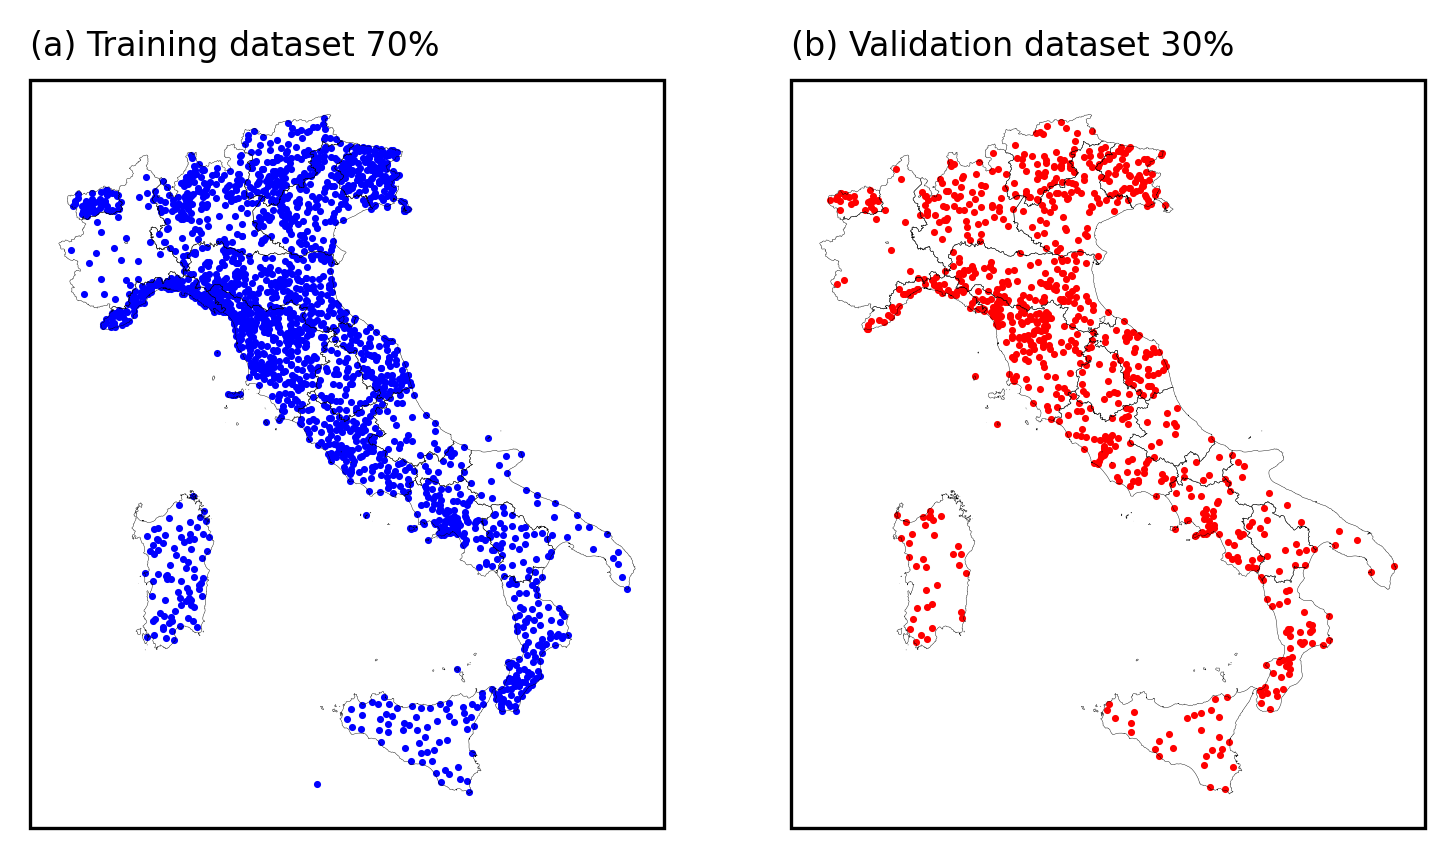

In [13]:
elev_cmap = plt.cm.Spectral_r

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,4),dpi=300)
gs = gridspec.GridSpec(1,2)

# =============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
REGIONS.plot(facecolor='None', ax=ax1, linewidth=0.1, zorder=10)
a1 = ax1.scatter(Q_80['Lon'],Q_80['Lat'],c='b',s=0.5)
ax1.set_title('(a) Training dataset 70%', loc='left',fontsize=8)

# =============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
REGIONS.plot(facecolor='None', ax=ax1, linewidth=0.1, zorder=10)
a1 = ax1.scatter(Q_20['Lon'],Q_20['Lat'],c='r',s=0.5)
ax1.set_title('(b) Validation dataset 30%', loc='left',fontsize=8)

In [14]:
playsound("../sound/HOMER_DOH.mp3")